In [1]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy as sp
import seaborn as sns
import xarray as xr

In [13]:
np.random.seed(0)
n_samples = 500

# Means for the four clusters
means = [0, 5, 10, 15, 20]
sample_sizes = [100, 300, 100, 500, 50]

# Variance (standard deviation squared) for all clusters
variance = 1

# Generate samples
data = []
for sample_size, mean in zip(sample_sizes, means):
    data.append(np.random.normal(mean, np.sqrt(variance), sample_size))

# Concatenate all data into a single array
data = np.concatenate(data).reshape(-1, 1)

# Turn data into DataFrame
sampled_data = pd.DataFrame(data, columns=['Value'])

sampled_data.head()  # Display the first few rows of the DataFrame

,Value
0,1.764052
1,0.400157
2,0.978738
3,2.240893
4,1.867558


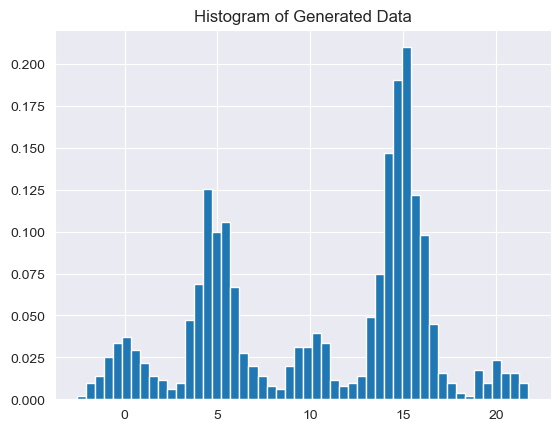

In [3]:
plt.hist(data, bins=50, density=True)
plt.title("Histogram of Generated Data")
plt.show()

In [4]:
N = sampled_data.shape[0]
K = 30

In [5]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [6]:
with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as model:
    alpha = pm.Gamma("alpha", 1.0, 1.0)
    beta = pm.Beta("beta", 1.0, alpha, dims="component")
    w = pm.Deterministic("w", stick_breaking(beta), dims="component")

    tau = pm.Gamma("tau", 1.0, 1.0, dims="component")
    lambda_ = pm.Gamma("lambda_", 10.0, 1.0, dims="component")
    mu = pm.Normal("mu", 0, tau=lambda_ * tau, dims="component")
    obs = pm.NormalMixture(
        "obs", w, mu, tau=lambda_ * tau, observed=sampled_data.Value.values, dims="obs_id"
    )

In [7]:
RANDOM_SEED = 42

with model:
    trace = pm.sample(
        tune=2500,
        init="advi",
        target_accept=0.975,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 90300
Interrupted at 90,299 [45%]: Average Loss = 8,402.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 960 seconds.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


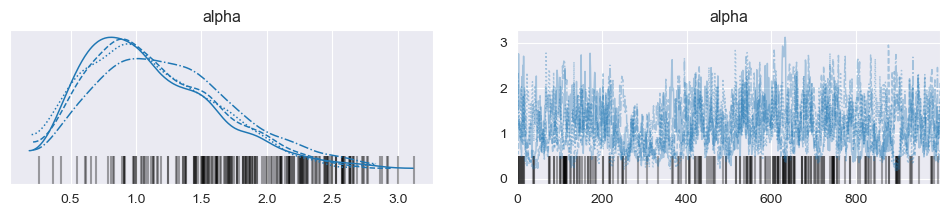

In [8]:
az.plot_trace(trace, var_names=["alpha"]);

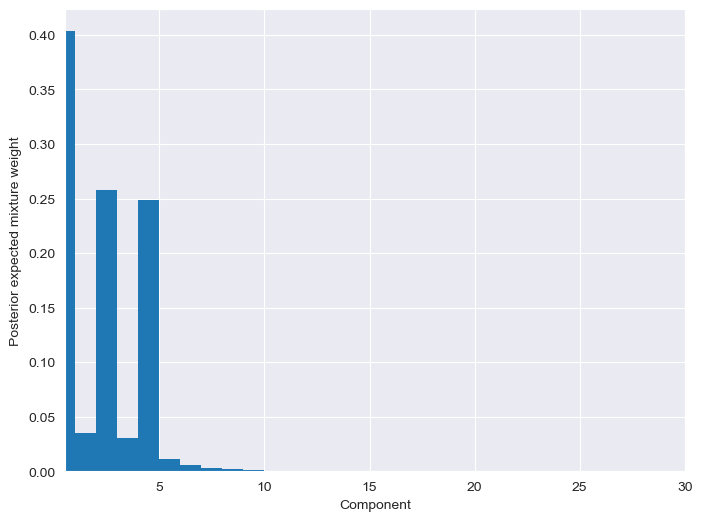

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace.posterior["w"].mean(("chain", "draw")), width=1.0, lw=0)

ax.set_xlim(0.5, K)
ax.set_xlabel("Component")

ax.set_ylabel("Posterior expected mixture weight");

In [10]:
x_plot = xr.DataArray(np.linspace(-10, 30, 200), dims=["plot"])
post_pdf_contribs = xr.apply_ufunc(
    sp.stats.norm.pdf,
    x_plot,
    trace.posterior["mu"],
    1.0 / np.sqrt(trace.posterior["lambda_"] * trace.posterior["tau"]),
)

post_pdfs = (trace.posterior["w"] * post_pdf_contribs).sum(dim=("component"))

post_pdf_quantiles = post_pdfs.quantile([0.1, 0.9], dim=("chain", "draw"))

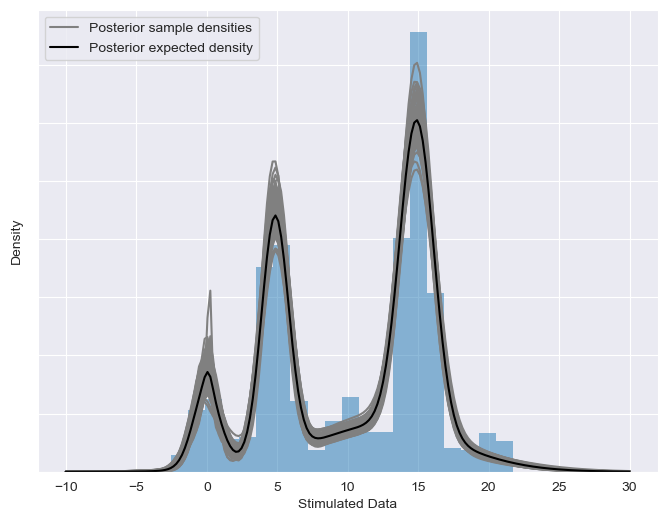

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(sampled_data.Value.values, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

ax.fill_between(
    x_plot,
    post_pdf_quantiles.sel(quantile=0.1),
    post_pdf_quantiles.sel(quantile=0.9),
    color="gray",
    alpha=0.45,
)

ax.plot(x_plot, post_pdfs.sel(chain=0, draw=0), c="gray", label="Posterior sample densities")
ax.plot(
    x_plot,
    az.extract(post_pdfs, var_names="x", num_samples=100),
    c="gray",
)
ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")

ax.set_xlabel("Stimulated Data")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

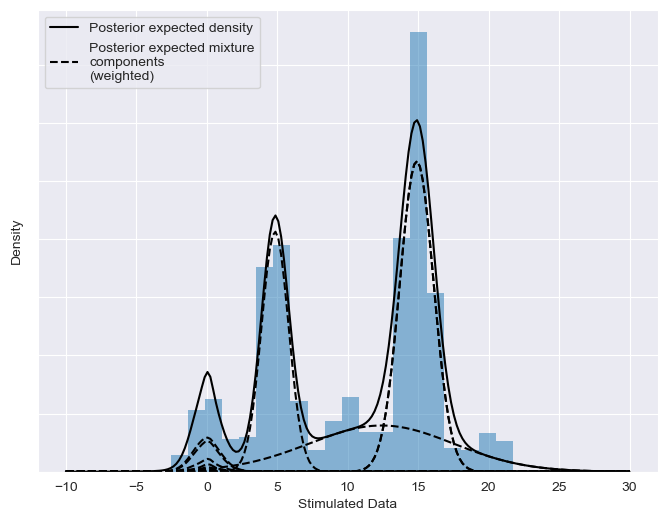

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(sampled_data.Value.values, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")
ax.plot(
    x_plot,
    (trace.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).sel(component=0),
    "--",
    c="k",
    label="Posterior expected mixture\ncomponents\n(weighted)",
)
ax.plot(
    x_plot,
    (trace.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).T,
    "--",
    c="k",
)

ax.set_xlabel("Stimulated Data")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

### Different Variance Settings

In [14]:
np.random.seed(0)
n_samples = 500
variances = [1, 2, 3, 4, 5, 6, 7]
datas = []
for variance in variances:
    data = []
    for sample_size,mean in zip(sample_sizes,means):
        data.append(np.random.normal(mean, np.sqrt(variance), sample_size))

    # Concatenate all data into a single array
    data = np.concatenate(data).reshape(-1)

    datas.append(data)

In [15]:
models = []
traces = []

def train_model(data):
    with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as model:
        alpha = pm.Gamma("alpha", 1.0, 1.0)#
        beta = pm.Beta("beta", 1.0, alpha, dims="component")
        w = pm.Deterministic("w", stick_breaking(beta), dims="component")

        tau = pm.Gamma("tau", 1.0, 1.0, dims="component")
        lambda_ = pm.Gamma("lambda_", 10.0, 1.0, dims="component")
        mu = pm.Normal("mu", 0, tau=lambda_ * tau, dims="component")
        obs = pm.NormalMixture(
            "obs", w, mu, tau=lambda_ * tau, observed=data, dims="obs_id"
        )
        RANDOM_SEED = 42

    with model:
        trace = pm.sample(
            tune=2500,
            init="advi",
            target_accept=0.975,
            random_seed=RANDOM_SEED,
        )
    return trace, model

for data in datas:
    trace, model = train_model(data)
    traces.append(trace)
    models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 90300
Interrupted at 90,299 [45%]: Average Loss = 8,402.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1096 seconds.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 81900
Interrupted at 81,899 [40%]: Average Loss = 8,939.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1369 seconds.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 100200
Interrupted at 100,199 [50%]: Average Loss = 7,712.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 2387 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 72200
Interrupted at 72,199 [36%]: Average Loss = 9,543.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1776 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 108500
Interrupted at 108,499 [54%]: Average Loss = 7,550.4
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1057 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 107500
Interrupted at 107,499 [53%]: Average Loss = 7,625.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1352 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 131200
Interrupted at 131,199 [65%]: Average Loss = 6,824.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 1387 seconds.
There were 283 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


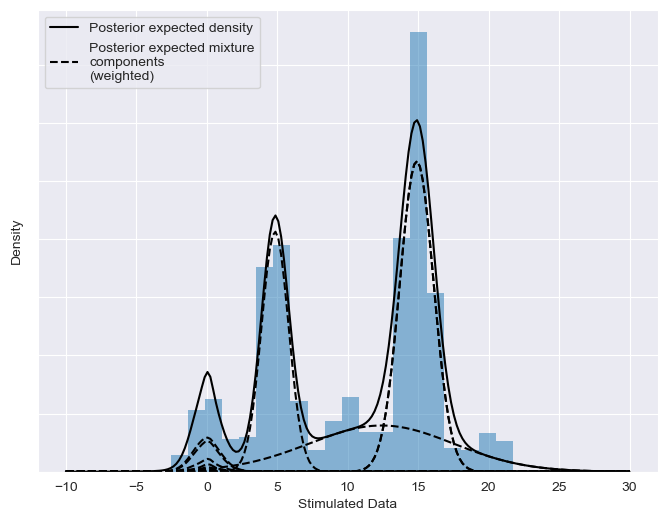

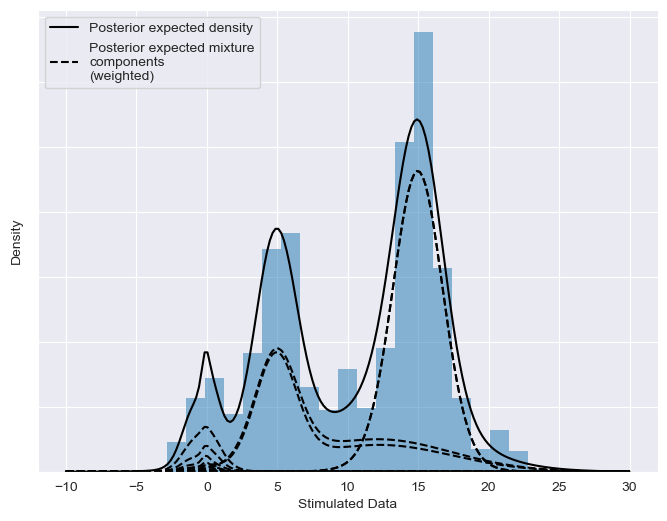

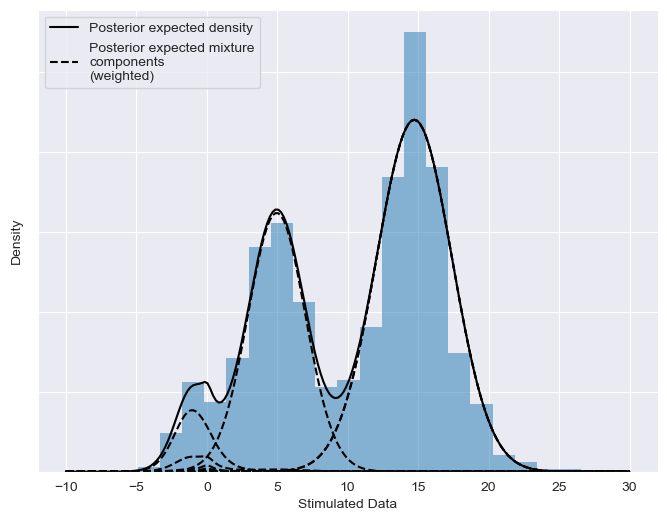

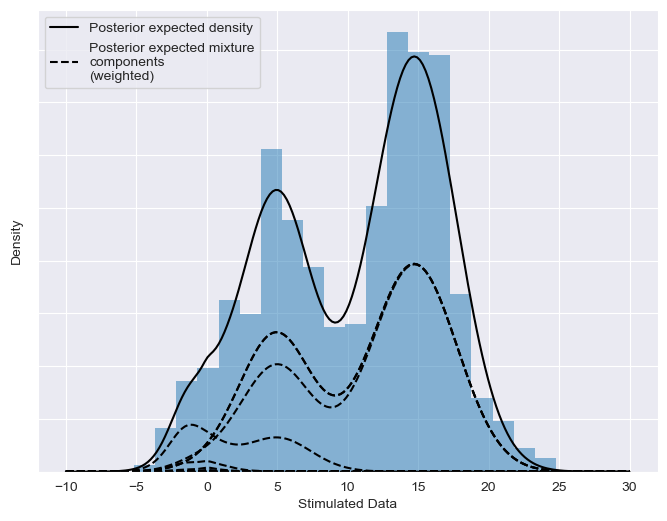

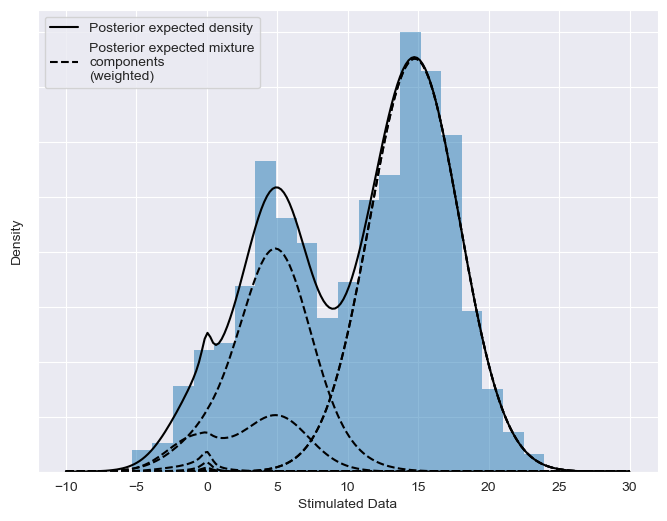

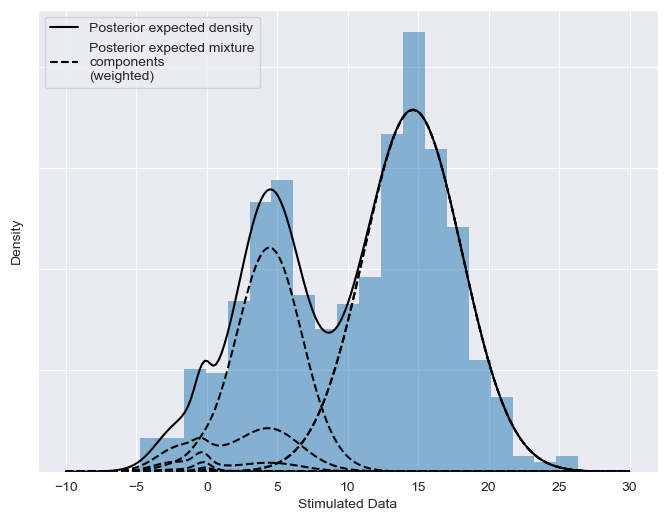

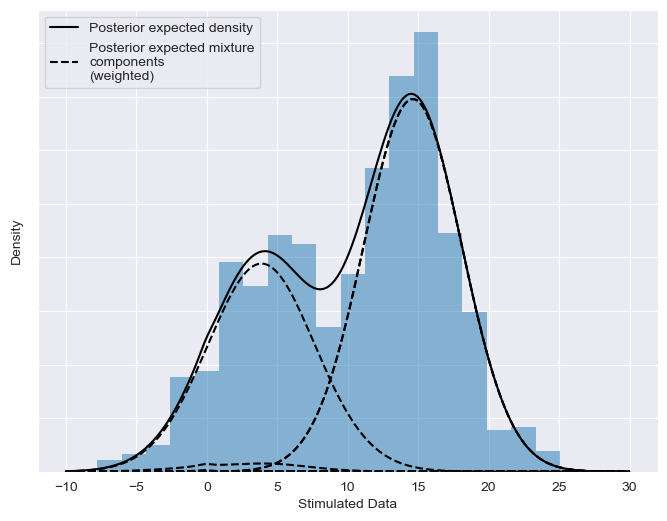

In [16]:
for model, data in zip(traces, datas):
    post_pdf_contribs = xr.apply_ufunc(
    sp.stats.norm.pdf,
    x_plot,
    model.posterior["mu"],
    1.0 / np.sqrt(model.posterior["lambda_"] * model.posterior["tau"]),
)

    post_pdfs = (model.posterior["w"] * post_pdf_contribs).sum(dim=("component"))

    post_pdf_quantiles = post_pdfs.quantile([0.1, 0.9], dim=("chain", "draw"))

    fig, ax = plt.subplots(figsize=(8, 6))

    n_bins = 20
    ax.hist(data, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

    ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")
    ax.plot(
        x_plot,
        (model.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).sel(component=0),
        "--",
        c="k",
        label="Posterior expected mixture\ncomponents\n(weighted)",
    )
    ax.plot(
        x_plot,
        (model.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).T,
        "--",
        c="k",
    )

    ax.set_xlabel("Stimulated Data")

    ax.set_yticklabels([])
    ax.set_ylabel("Density")

    ax.legend(loc=2);